# Bike Sharing Demand Kaggle project

W207 Final Project

Chris Murray, Rahul Ragunathan, Rajagopalan Mahadevan

https://www.kaggle.com/c/bike-sharing-demand/


In [6]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.decomposition import PCA

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

## Define a function to read data file

Data fields are described here: https://www.kaggle.com/c/bike-sharing-demand/data

Note that we extract several features from the datatime field and ignore other fields.  Our final data fields are as follows:

`month,dayofweek,hour,workingday,weather,atemp,humidity,windspeed`

In [3]:
def read_timestamps(filename):
    datafile = open(filename)
    timestamps = np.genfromtxt(datafile, delimiter=",", skip_header=1, dtype=str, usecols=0)

    months = []
    daysofweek = []
    hours = []
   
    for t in timestamps:
        t = dt.datetime.strptime(t, '%Y-%m-%d %H:%M:%S')
        months.append(t.month)
        daysofweek.append(t.weekday())
        hours.append(t.hour)
        
    months = np.array(months)
    daysofweek = np.array(daysofweek)
    hours = np.array(hours)
    
    return timestamps, months, daysofweek, hours


def read_data(filename):
    # define a conversion function to convert string to float and round to integer
    getRounded = lambda x: int(round(float(x)))

    # read data file and convert everything to integers
    # columns: 0=datetime,1=season,2=holiday,3=workingday,4=weather,5=temp,6=atemp,7=humidity,8=windspeed

    datafile = open(filename)
    data = np.genfromtxt(datafile, delimiter=",", skip_header=1, dtype=int, usecols=(1,3,4,6,7,8),
                converters= {5: getRounded, 6: getRounded, 8: getRounded})

    # read and convert timestamps from file
    timestamps, months, daysofweek, hours = read_timestamps(filename)

    # insert timedata into our data array
    data = np.insert(data, 0, months, axis=1)
    data = np.insert(data, 1, daysofweek, axis=1)
    data = np.insert(data, 2, hours, axis=1)
    
    return data, timestamps


def read_labels(filename):
    # read data file and convert everything to integers
    # columns:  9=casual,10=registered,11=count

    datafile = open(filename)
    data = np.genfromtxt(datafile, delimiter=",", skip_header=1, dtype=int, usecols=(9,10,11))
        
    return data


## Read training and test data

In [4]:
train_filename = "data/train.csv"
test_filename = "data/test.csv"

train_data, train_datetimes = read_data(train_filename)
train_labels = read_labels(train_filename)

# extract the last 3 columns (casual + registered = count)
train_casual = train_labels[:, 0]
train_registered = train_labels[:, 1]
train_count = train_labels[:, 2]

print "Sample training data:"
print train_data[0:5]

print "\nSample training labels:"
print train_labels[0:5]

# read test data and print a sample
test_data, test_datetimes = read_data(test_filename)
print "\nSample test data:"
print test_data[0:5]


Sample training data:
[[ 1  5  0  1  0  1 14 81  0]
 [ 1  5  1  1  0  1 14 80  0]
 [ 1  5  2  1  0  1 14 80  0]
 [ 1  5  3  1  0  1 14 75  0]
 [ 1  5  4  1  0  1 14 75  0]]

Sample training labels:
[[ 3 13 16]
 [ 8 32 40]
 [ 5 27 32]
 [ 3 10 13]
 [ 0  1  1]]

Sample test data:
[[ 1  3  0  1  1  1 11 56 26]
 [ 1  3  1  1  1  1 14 56  0]
 [ 1  3  2  1  1  1 14 56  0]
 [ 1  3  3  1  1  1 13 56 11]
 [ 1  3  4  1  1  1 13 56 11]]


## Visualize data

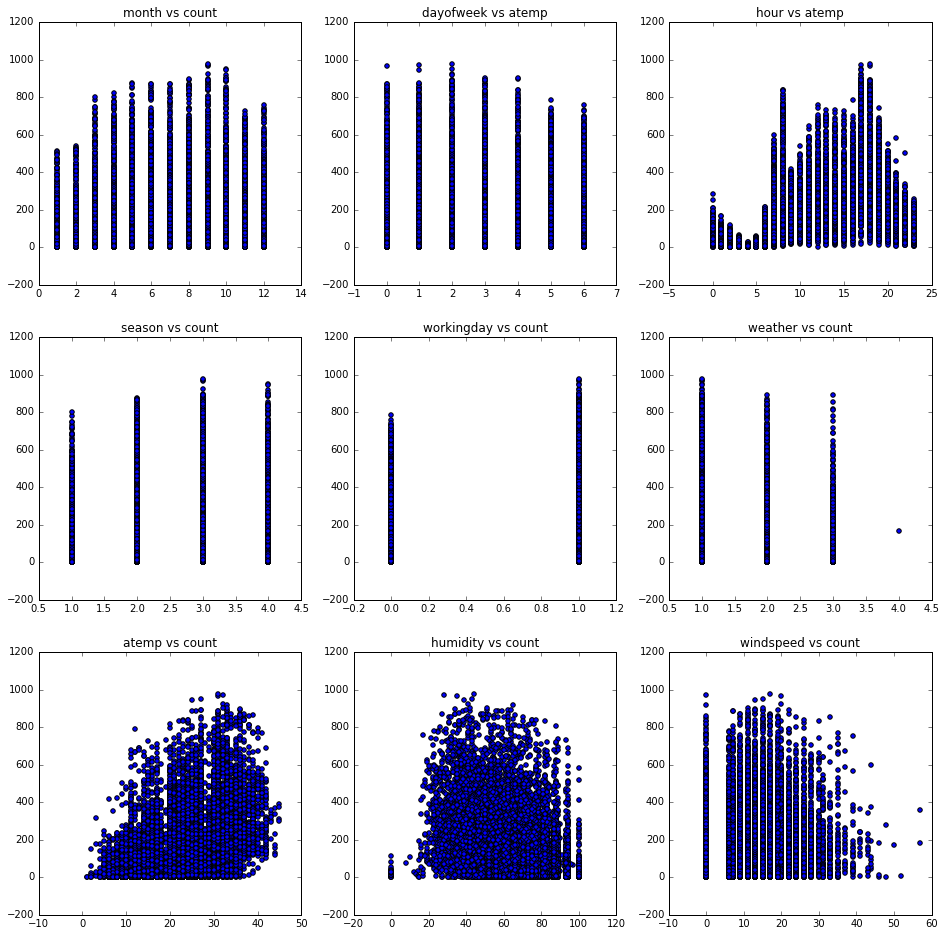

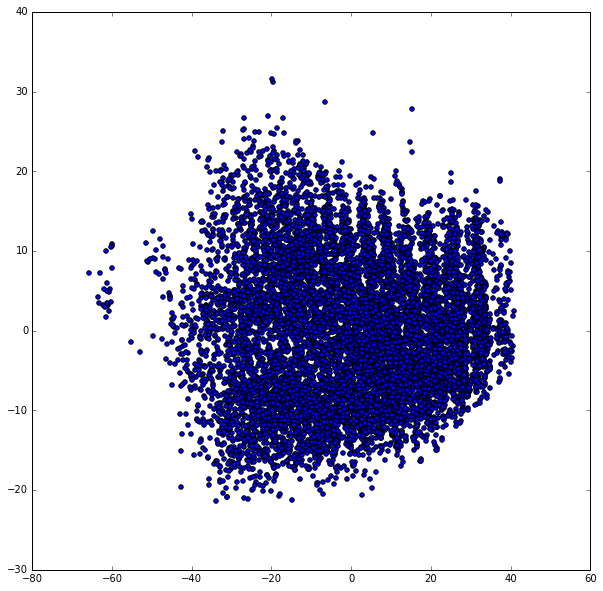

In [37]:
# month,dayofweek,hour,workingday,weather,atemp,humidity,windspeed

month = train_data[:,0]
dayofweek = train_data[:,1]
hour = train_data[:,2]
season = train_data[:,3]
workingday = train_data[:,4]
weather = train_data[:,5]
atemp = train_data[:,6]
humidity = train_data[:,7]
windspeed = train_data[:,8]
count = train_labels[:,2]

plt.figure(figsize=(16, 16))

p = plt.subplot(3, 3, 1)
plt.title('month vs count')
p.scatter(month, count)

p = plt.subplot(3, 3, 2)
p.scatter(dayofweek, count)
plt.title('dayofweek vs atemp')

p = plt.subplot(3, 3, 3)
p.scatter(hour, count)
plt.title('hour vs atemp')

p = plt.subplot(3, 3, 4)
plt.title('season vs count')
p.scatter(season, count)

p = plt.subplot(3, 3, 5)
plt.title('workingday vs count')
p.scatter(workingday, count)

p = plt.subplot(3, 3, 6)
plt.title('weather vs count')
p.scatter(weather, count)

p = plt.subplot(3, 3, 7)
plt.title('atemp vs count')
p.scatter(atemp, count)

p = plt.subplot(3, 3, 8)
plt.title('humidity vs count')
p.scatter(humidity, count)

p = plt.subplot(3, 3, 9)
plt.title('windspeed vs count')
p.scatter(windspeed, count)

plt.show()

# Do PCA just for the heck of it
pca = PCA(n_components=2)
train_data_2d = pca.fit_transform(train_data)
plt.figure(figsize=(10, 10))
plt.scatter(train_data_2d[:, 0], train_data_2d[:, 1])
plt.show()



## Define CSV output function

In [4]:
def writecsv(filename, predictions, datetime):
    
    # open output file and write header row
    outfile = open(filename, "w")
    outfile.write("datetime,count\n")

    # output all the predictions to the file
    for i in range(len(predictions)):
        outfile.write("{},{}\n".format(datetime[i], preds[i]))

    print "{} results written to {}".format(i, output_filename)


## Generate predictions

### K Nearest Neighbors

In [5]:
for k in [1,3,5,7,9]:
    output_filename = 'submission_knn_{}.csv'.format(k)

    # train a model and generate predictions
    kn = KNeighborsClassifier(n_neighbors=k)
    kn.fit(train_data, train_count)
    preds = kn.predict(test_data)
    
    writecsv(output_filename, preds, test_datetimes)


6492 results written to submission_knn_1.csv
6492 results written to submission_knn_3.csv
6492 results written to submission_knn_5.csv
6492 results written to submission_knn_7.csv
6492 results written to submission_knn_9.csv


Kaggle submission results for KNN (k=1):  0.96793

### Decision Tree

In [6]:
output_filename = 'submission_dtree.csv'
    
# train a model and generate predictions
clf = DecisionTreeClassifier(random_state=0)
clf.fit(train_data, train_count)
preds = clf.predict(test_data)

writecsv(output_filename, preds, test_datetimes)


6492 results written to submission_dtree.csv


Predict **casual** users and **registered** users separately and then add together to get total **count** of users.

Kaggle submission results for Decision Tree: 0.62940

In [7]:
output_filename = 'submission_dtree_separate.csv'

# train a model and generate predictions
clf = DecisionTreeClassifier(random_state=0)
clf.fit(train_data, train_casual)
preds_casual = clf.predict(test_data)

clf = DecisionTreeClassifier(random_state=0)
clf.fit(train_data, train_registered)
preds_registered = clf.predict(test_data)

preds = preds_casual + preds_registered

writecsv(output_filename, preds, test_datetimes)


6492 results written to submission_dtree_separate.csv


Kaggle submission results for Decision Tree with separate predictions: 0.58618

### Random Forest

In [8]:
for n in [10, 50, 100]:
    output_filename = 'submission_rforest_{}.csv'.format(n)

    # train a model and generate predictions
    rfc = RandomForestClassifier(n_estimators=n)
    rfc.fit(train_data, train_casual)
    preds_casual = rfc.predict(test_data)

    rfc = RandomForestClassifier(n_estimators=n)
    rfc.fit(train_data, train_registered)
    preds_registered = rfc.predict(test_data)

    preds = preds_casual + preds_registered

    writecsv(output_filename, preds, test_datetimes)


6492 results written to submission_rforest_10.csv
6492 results written to submission_rforest_50.csv
6492 results written to submission_rforest_100.csv


Kaggle submission results for Random Forest (n=100): 0.61908